### Generating Images with GANs





Generative Adversarial Network (GAN)
- A GAN is a generation model trained to convert the samples from prior distribution $z$ to the target domains $x$, e.g., images or text, in an unsupervised fashion.
- A GAN consists of a generator (G) and discriminator (D) model, where $G$ is trained to produce realistic samples of the target domain, while the $D$ learns to identified the samples from generator and the real domain, and serve as the supervision to optimize the $G$.
- GAN training iterative steps:

  1. $\max_D \log\left(D\left(x\right)\right) + \log\left(1 - D\left(G\left(z\right)\right)\right)$
  2. $\max_G \log\left(D\left(G\left(z\right)\right)\right)$

In [ ]:
"""
Import PyTorch libraries.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
"""
Enable CUDA if the GPU is available
"""
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Ankle Boot


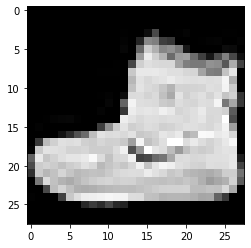

In [ ]:
"""
Define the dataloader for the Fashion MNIST dataset.
"""
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(output_label(label))

#### GAN Model


In [ ]:
"""
Specify the weights initialization
"""
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

"""
Define the generator
"""
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.layers = nn.Sequential(nn.ConvTranspose2d(100, 128, 3, 1, 0, bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(128, 64, 4, 2, 0, bias=False),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(64, 32, 4, 1, 0, bias=False),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(32, 16, 4, 2, 0, bias=False),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(16, 1, 5, 1, 0, bias=False),
                                    nn.Tanh())

    def forward(self, input):
        return self.layers(input)

"""
Define the discriminator
"""
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.layers = nn.Sequential(nn.Conv2d(1, 16, 5, bias=False),
                                    nn.BatchNorm2d(16),
                                    nn.LeakyReLU(0.1),
                                    nn.Conv2d(16, 32, 5, bias=False),
                                    nn.BatchNorm2d(32),
                                    nn.LeakyReLU(0.1),
                                    nn.Conv2d(32, 64, 4, 2, bias=False),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(0.1),
                                    nn.Conv2d(64, 128, 4, 2, bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.1),
                                    nn.Conv2d(128, 1, 3, 1, bias=False),
                                    nn.Sigmoid())

    def forward(self, input):
        return self.layers(input)

In [ ]:
"""
Initialize Hyperparameters
"""
lr = 0.0002
num_epochs = 30

"""
Initialize the network and the Adam optimizer
"""
beta = 0.5
G = generator().to(device)
D = discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta, 0.999))
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta, 0.999))
loss_func = nn.BCELoss()

"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        # train the discriminator on input data
        D.zero_grad()
        real_imgs = data[0].to(device)
        batch_size = real_imgs.size(0)
        label = torch.full((batch_size,), 1., dtype=torch.float, device=device) # all 1s since all real data
        output = D(real_imgs).view(-1)
        D_loss_real = loss_func(output, label)
        D_loss_real.backward()

        # train with entirely fake inputs
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake = G(noise)
        label.fill_(0.) # all 0s since all fake data
        output = D(fake.detach()).view(-1)
        D_loss_fake = loss_func(output, label)
        D_loss_fake.backward()
        D_loss = D_loss_real + D_loss_fake
        D_opt.step()

        # train the generator
        G.zero_grad()
        label.fill_(1.)
        output = D(fake).view(-1)
        G_loss = loss_func(output, label)
        G_loss.backward()
        G_opt.step()

        if i % 300 == 0 or i == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, i, D_loss.item(), G_loss.item()))

Epoch 0 Iteration 0: discriminator_loss 1.268 generator_loss 1.124
Epoch 0 Iteration 300: discriminator_loss 0.793 generator_loss 5.221
Epoch 1 Iteration 0: discriminator_loss 0.341 generator_loss 2.501
Epoch 1 Iteration 300: discriminator_loss 0.729 generator_loss 3.004
Epoch 2 Iteration 0: discriminator_loss 0.352 generator_loss 2.804
Epoch 2 Iteration 300: discriminator_loss 0.346 generator_loss 3.777
Epoch 3 Iteration 0: discriminator_loss 0.352 generator_loss 3.603
Epoch 3 Iteration 300: discriminator_loss 2.040 generator_loss 5.885
Epoch 4 Iteration 0: discriminator_loss 0.412 generator_loss 2.840
Epoch 4 Iteration 300: discriminator_loss 0.953 generator_loss 2.693
Epoch 5 Iteration 0: discriminator_loss 0.423 generator_loss 3.530
Epoch 5 Iteration 300: discriminator_loss 0.456 generator_loss 2.665
Epoch 6 Iteration 0: discriminator_loss 0.498 generator_loss 2.586
Epoch 6 Iteration 300: discriminator_loss 0.953 generator_loss 3.729
Epoch 7 Iteration 0: discriminator_loss 0.630 ge

#### Visualizing the output

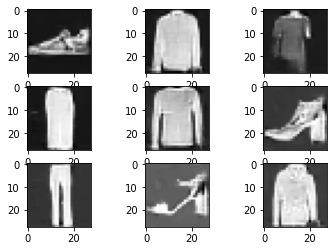

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,3)
ax = ax.reshape(-1)
for i in range(9):
  ax[i].imshow(fake[i,0].cpu().data.numpy(), cmap = 'gray')
plt.show()